### Import the necessary library

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import tempfile
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore", category=ImportWarning, message=".*AltairImportHook.find_spec() not found; falling back to find_module.*")

### read the data

In [4]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/Lung_atlas_public/Lung_atlas_public.h5ad")
adata = anndata.read_h5ad("../Lung_atlas_public.h5ad")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [5]:
# load the prediction results to adata
predict_labels = pd.read_csv("../R_lung_atlas/labels/TOSICA_label_lung_atlas_obs.csv")

adata.obs['predict_labels'] = predict_labels['tosica_labels'].values

In [6]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
embeddings_dict = {}

# scANVI

In [ ]:
# scVI training -- no need to run every time
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Save the VAE model to a file named 'model.pt'
save_path = "./model_scVI"
vae.save(save_path)

In [8]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     File ./model_scVI/model.pt already downloaded                                                             


/Users/sheena/Library/Python/3.9/lib/python/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [9]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

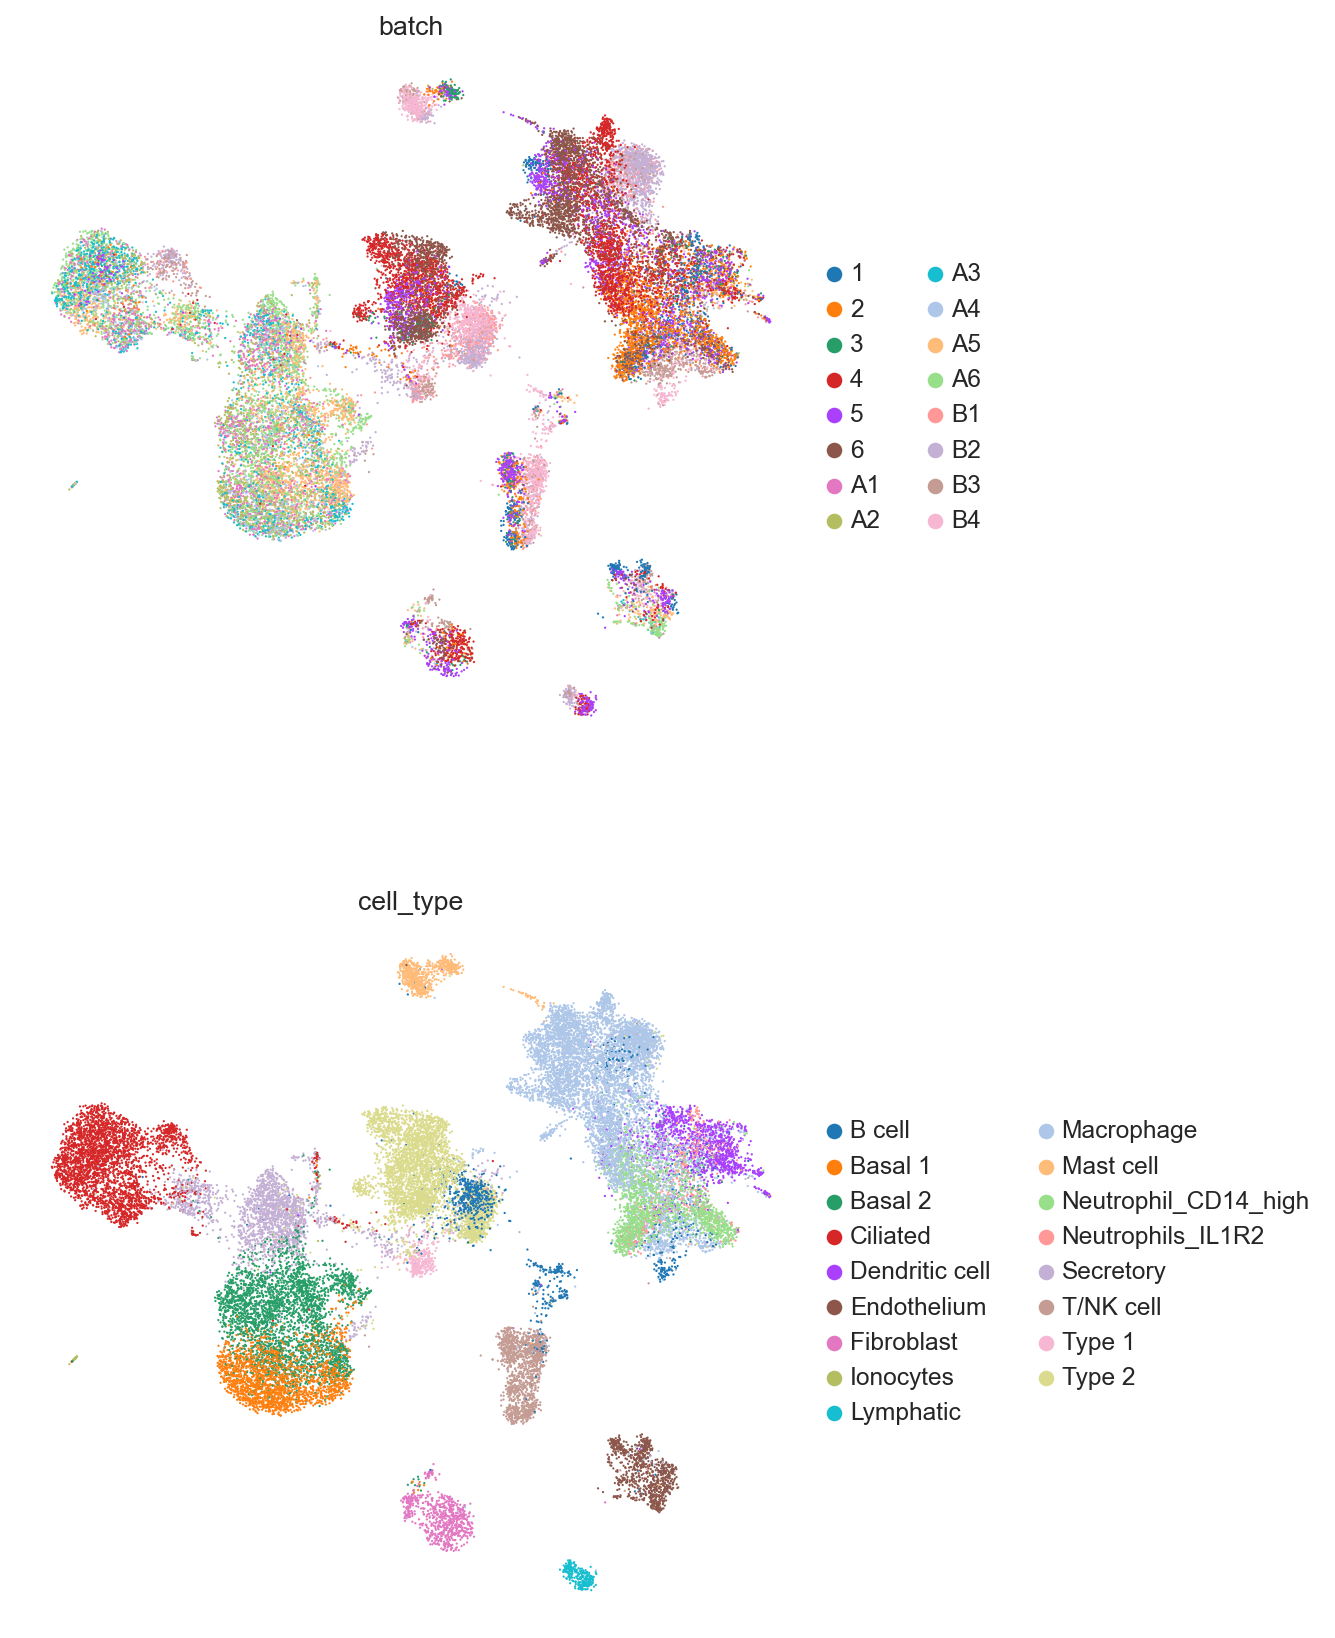

In [10]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [11]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="predict_labels",
    unlabeled_category="Unknown",
)

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [12]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [02:45<00:00,  8.70s/it, v_num=1, train_loss_step=395, train_loss_epoch=409]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:45<00:00,  8.29s/it, v_num=1, train_loss_step=395, train_loss_epoch=409]


In [13]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [14]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict['X_scANVI'] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [15]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

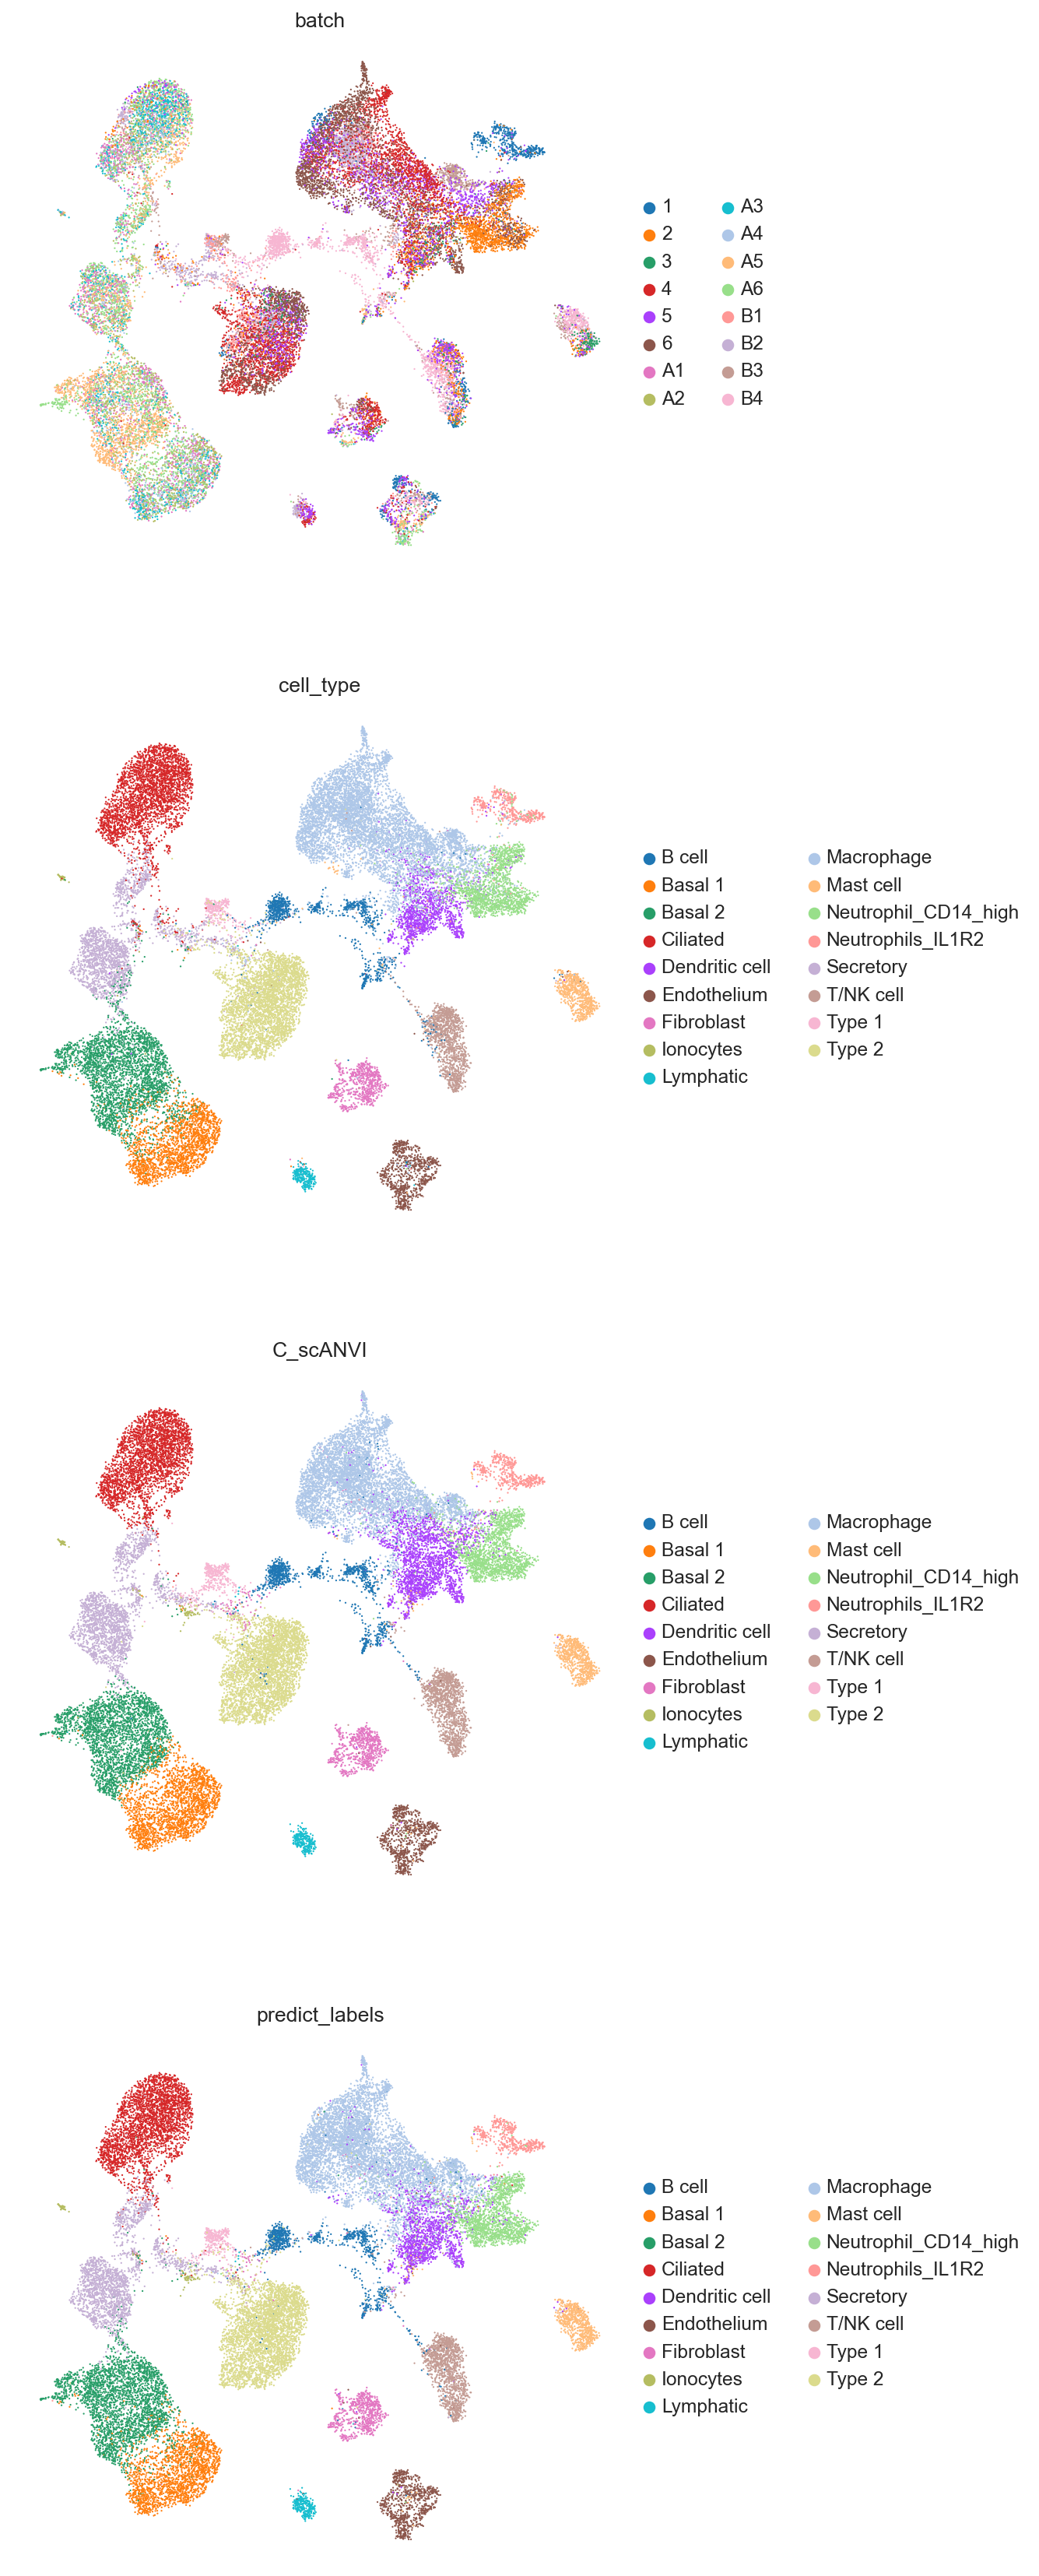

In [16]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI",  "predict_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [17]:
train = adata.copy()

### Preprocessing Data

In [18]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="predict_labels")

## Creating and Training the model¶

In [19]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sheena/Library/Python/3.9/lib/python/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 26/100:  26%|██▌       | 26/100 [05:46<16:25, 13.31s/it, v_num=1, train_loss_step=182, train_loss_epoch=193]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1131.177. Signaling Trainer to stop.


## Batch-Removal

In [20]:
corrected_adata = model.batch_removal()
corrected_adata

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scgen/_scgen.py:268: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  all_shared_ann = AnnData.concatenate(


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 29256 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'predict_labels', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [21]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [22]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

/Users/sheena/Library/Python/3.9/lib/python/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


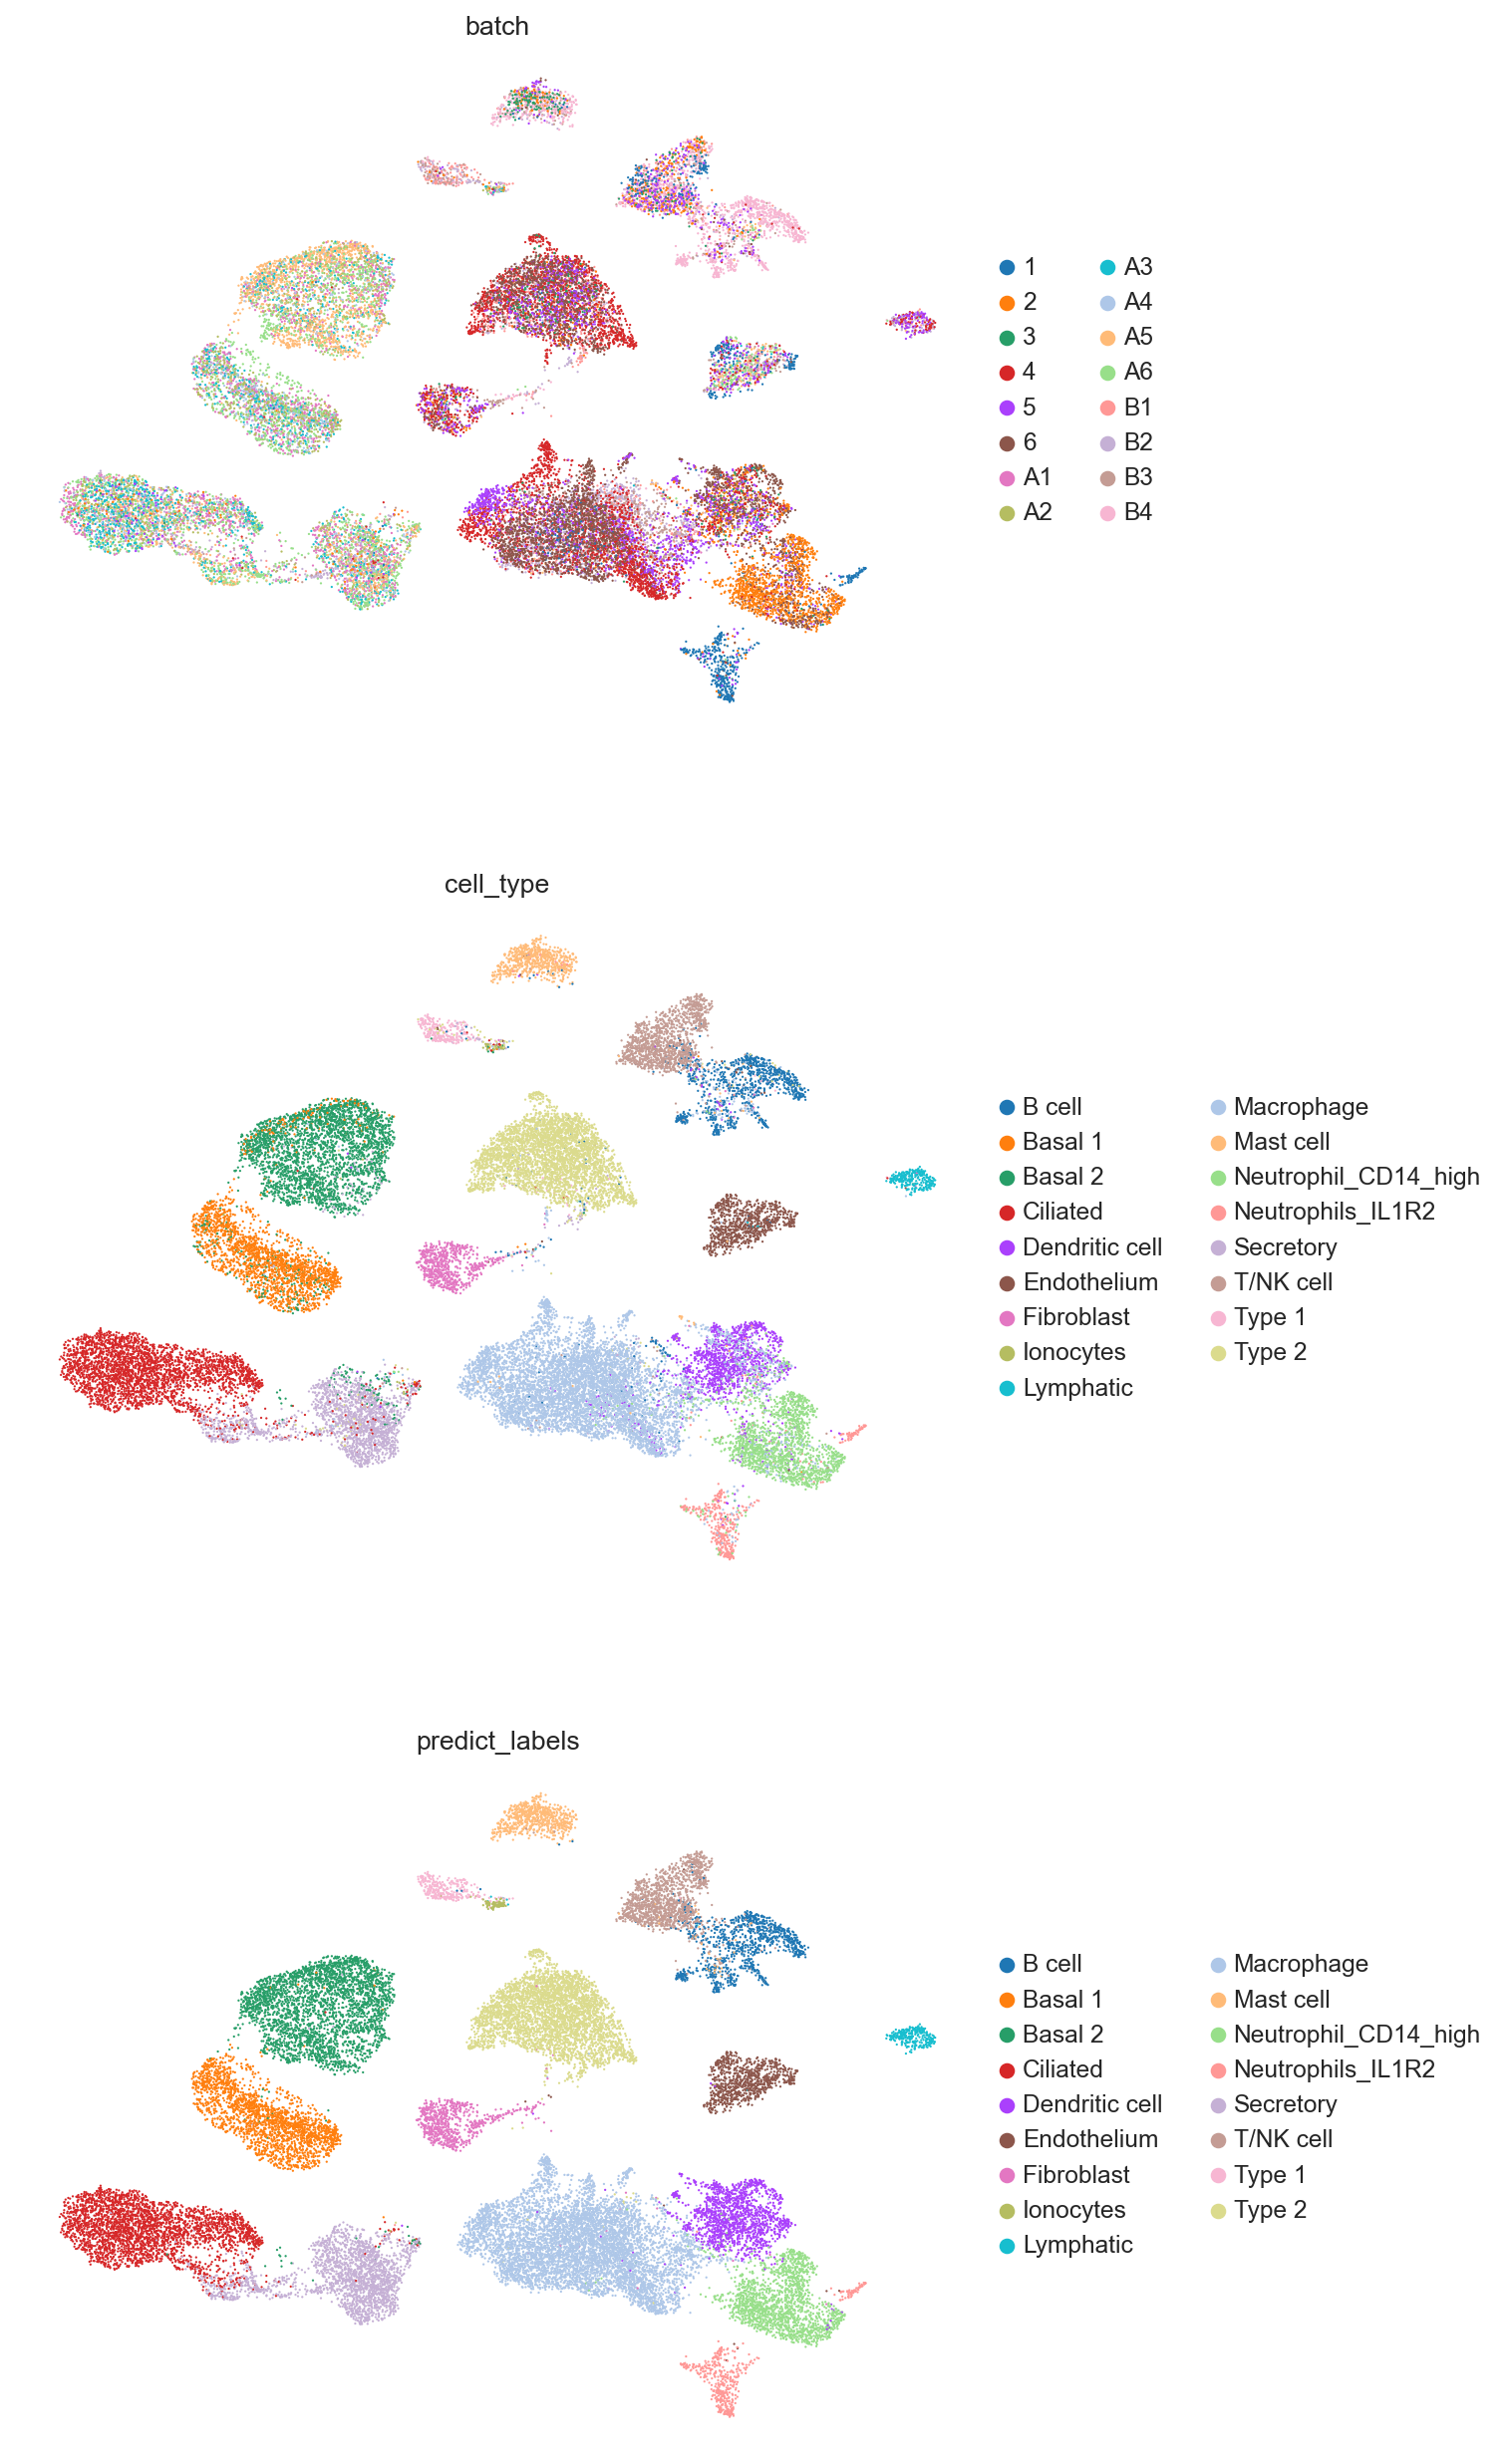

In [23]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', "predict_labels"], wspace=0.4, frameon=False, ncols = 1)

# STACAS

Semi-supervised integration results

In [24]:
pca_embeddings = pd.read_csv('../R_lung_atlas/embeddings/lung_atlas_stacas_tosica.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [25]:
# Collect embeddings
embeddings_dict["X_stacas"] = adata.obsm['X_stacas']

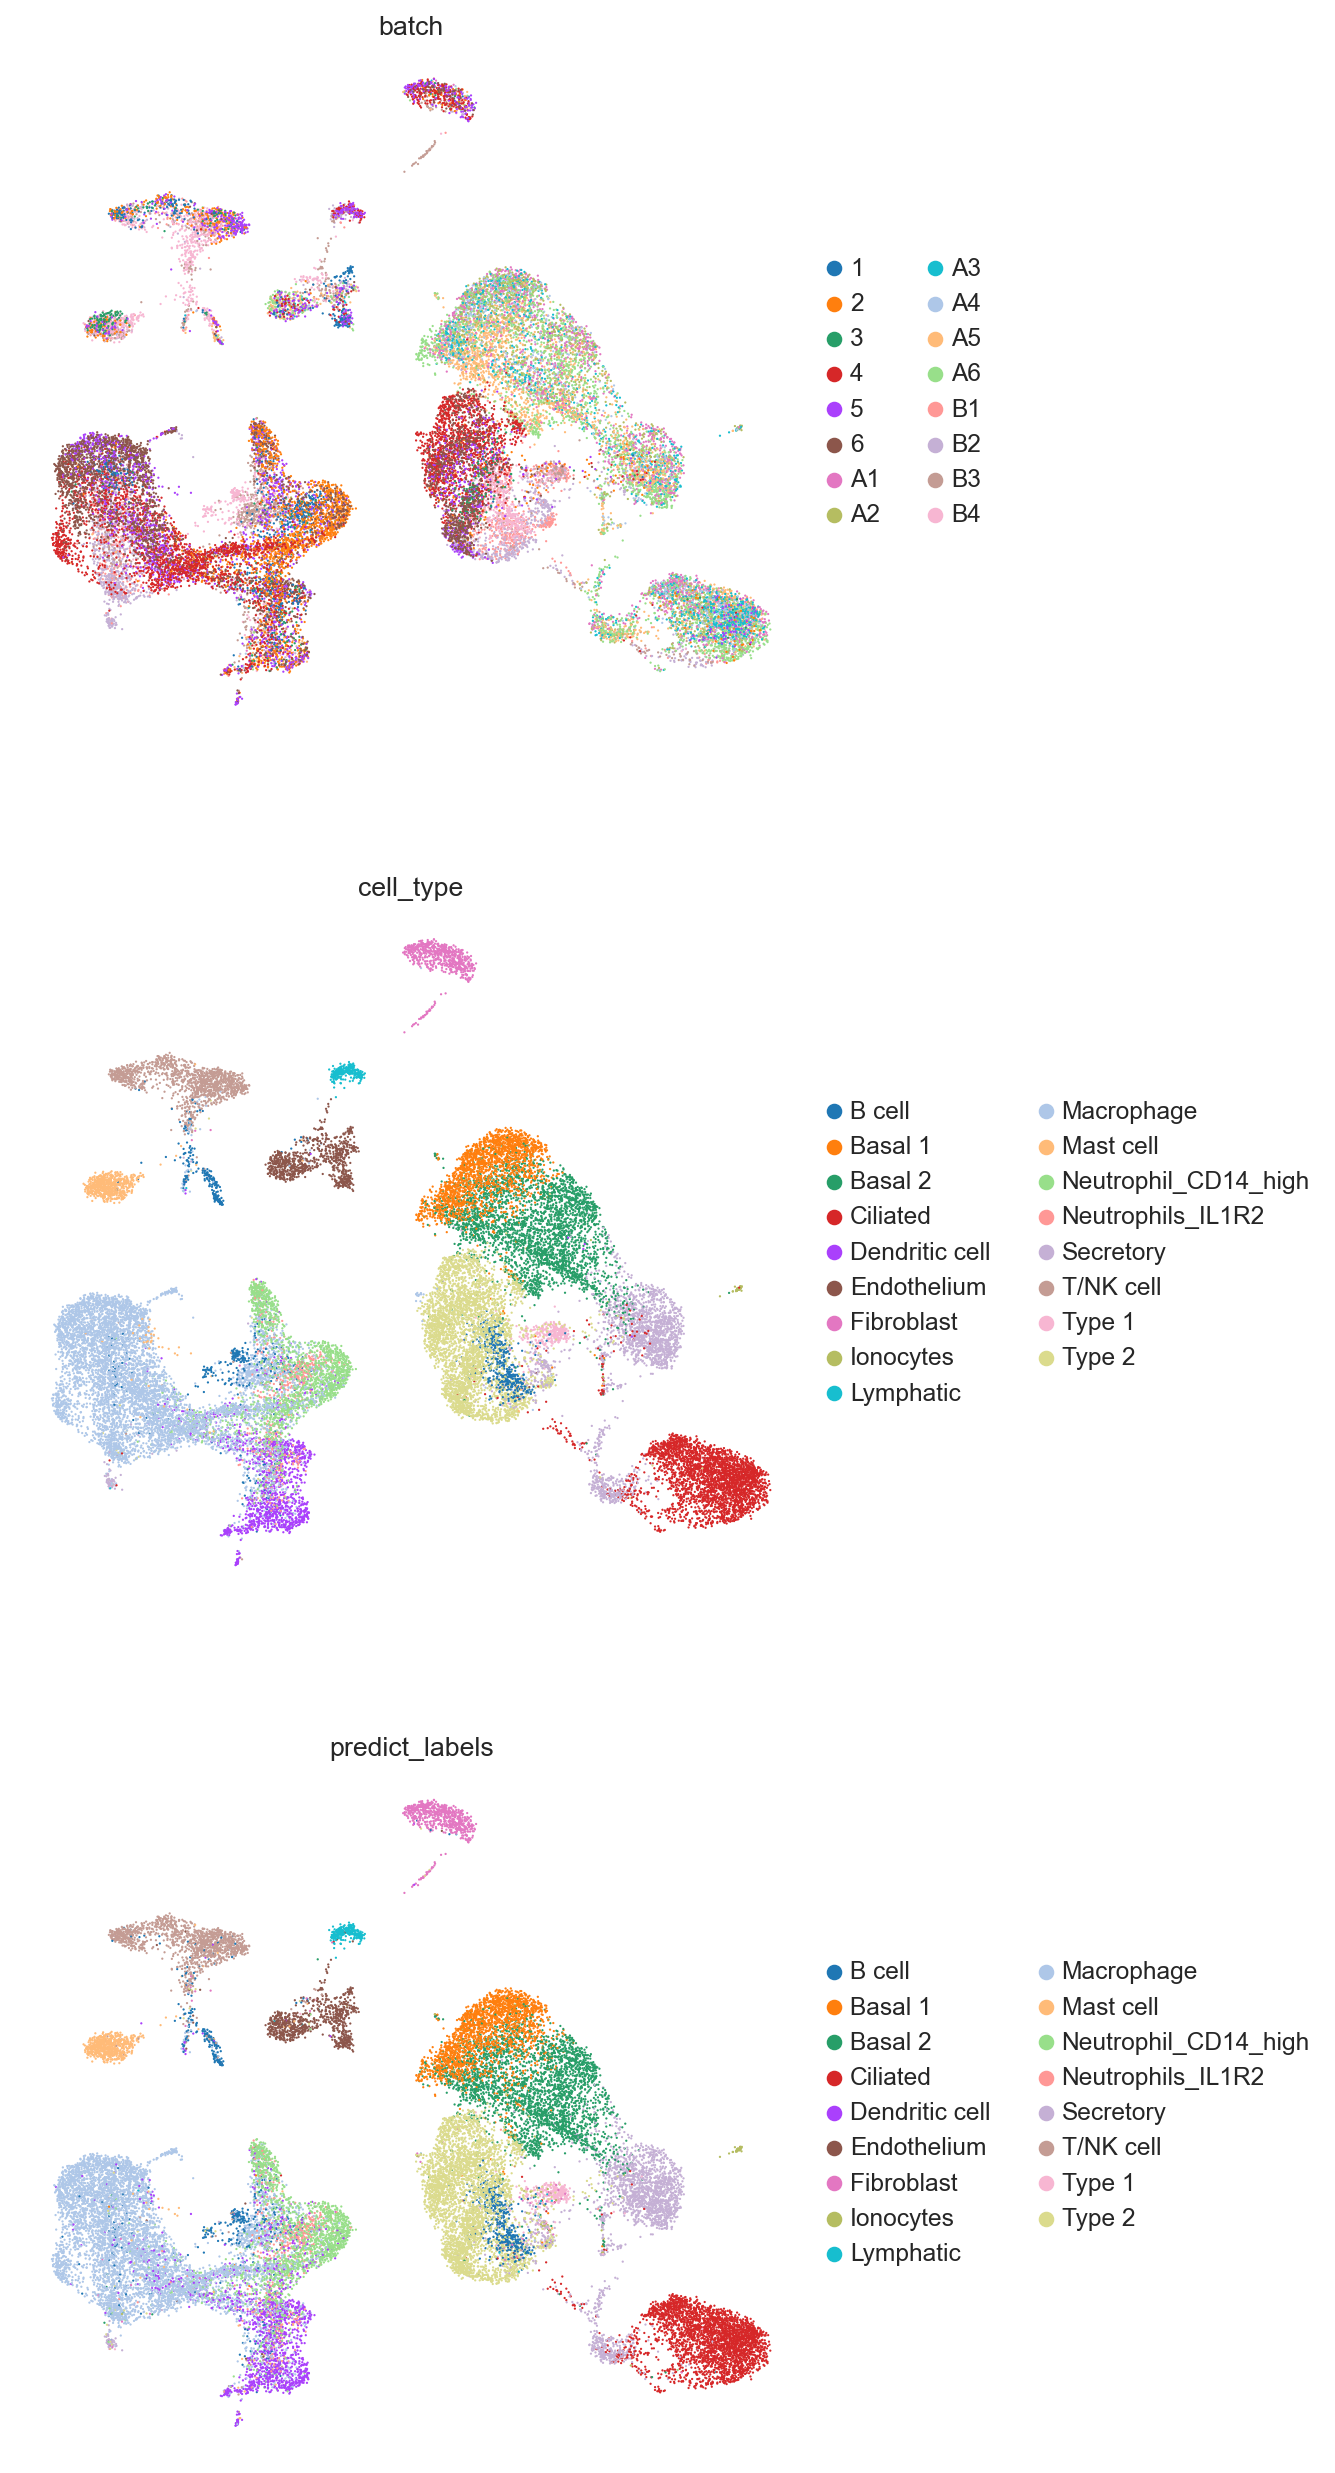

In [26]:
sc.pl.umap(adata, color=["batch", "cell_type", "predict_labels"], frameon=False, ncols=1)

In [27]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/tosica_lung_atlas.csv")


### others

In [11]:
embeddings_old = pd.read_csv('../embeddings/tosica_lung_atlas.csv', index_col=0)
embeddings_new = pd.read_csv('../embeddings/tosica_lung_atlas_new.csv', index_col=0)

In [18]:
import pandas as pd

# 1. 读取数据
embeddings_old = pd.read_csv('../embeddings/tosica_lung_atlas_old.csv', index_col=0)
embeddings_new = pd.read_csv('../embeddings/tosica_lung_atlas_new.csv', index_col=0)

# 2. 执行对齐 (Align)
# 这行代码会让 embeddings_new 的行顺序、行内容完全匹配 embeddings_old 的索引
embeddings_new_aligned = embeddings_new.reindex(embeddings_old.index)

# 3. 检查对齐结果
print(f"Old shape: {embeddings_old.shape}")
print(f"New aligned shape: {embeddings_new_aligned.shape}")

# 检查是否有因为对齐而产生的空值 (意味着 embeddings_new 里缺少了 old 里有的细胞)
missing_cells = embeddings_new_aligned.isna().any(axis=1).sum()
if missing_cells > 0:
    print(f"警告: 有 {missing_cells} 个细胞在 old 中存在但在 new 中找不到 (被填充为 NaN)。")
else:
    print("完美对齐，没有缺失值。")

# 4. 保存结果 (如果需要)
embeddings_new_aligned.to_csv('../embeddings/tosica_lung_atlas_merged.csv')

Old shape: (29256, 251)
New aligned shape: (29256, 42)
完美对齐，没有缺失值。


In [13]:
# align the indices of both dataframes
embeddings_new = embeddings_new.loc[embeddings_old.index]


In [14]:
embeddings_new.shape

(29256, 42)

In [ ]:
# merge the df together on their indices, but do not change the column name
merged_embeddings = pd.concat([embeddings_old, embeddings_new], axis=1)
merged_embeddings.to_csv('../embeddings/tosica_lung_atlas_merged.csv')

In [20]:
import pandas as pd

# ================= 配置路径 =================
# 请修改为你的实际文件路径
embedding_file = '../embeddings/tosica_lung_atlas_merged.csv'  # 基准文件 (Embedding)
metadata_file  = '../embeddings/TOSICA_label_lung_atlas_obs.csv'        # 需要修改的文件 (Metadata)
output_file    = '../embeddings/tosica_lung_atlas_obs.csv'     # 保存的新文件
# ===========================================

# 1. 读取数据
# index_col=0 表示把第一列当作索引 (Cell ID)
print(f"正在读取 Embedding: {embedding_file} ...")
df_emb = pd.read_csv(embedding_file, index_col=0)

print(f"正在读取 Metadata: {metadata_file} ...")
df_meta = pd.read_csv(metadata_file, index_col=0)

# --- 特殊处理 (如果 Embedding 文件头部有脏数据) ---
# 之前你的 R 代码里删除了前两行 ([-c(1,2)])。
# 如果你在 Python 里读出来的 df_emb 前两行也是无效的 header/注释，
# 这里建议先手动删掉，否则生成的 metadata 也会多出两行空数据。
# 如果 df_emb 读出来是干净的，注释掉下面这两行即可：
# df_emb = df_emb.iloc[2:] 
# print("已移除 Embedding 前两行脏数据 (根据之前的 R 代码逻辑)")

# 2. 核心步骤：执行对齐 (Reindex)
# 这会让 df_meta 的索引完全变成 df_emb 的索引
# 自动丢弃多余行，自动填充缺失行，自动排序
print("正在对齐 Metadata ...")
df_meta_aligned = df_meta.reindex(df_emb.index)

# 3. 检查对齐质量
print("-" * 30)
print(f"Embedding 行数: {len(df_emb)}")
print(f"Metadata  行数: {len(df_meta_aligned)}")

# 检查是否有细胞在 Embedding 里有，但在 Metadata 里找不到 (变成了 NaN)
missing_cells = df_meta_aligned.isna().all(axis=1).sum()
if missing_cells > 0:
    print(f"⚠️ 警告: 有 {missing_cells} 个细胞在 Embedding 中存在，但在 Metadata 中找不到！")
    print("这些行在新的 Metadata 中被填充为了空值 (NaN)。")
else:
    print("✅ 完美对齐，所有细胞都找到了对应的 Metadata。")

# 4. 保存结果
df_meta_aligned.to_csv(output_file)
print("-" * 30)
print(f"成功！已保存对齐后的文件到: {output_file}")

正在读取 Embedding: ../embeddings/tosica_lung_atlas_merged.csv ...
正在读取 Metadata: ../embeddings/TOSICA_label_lung_atlas_obs.csv ...
正在对齐 Metadata ...
------------------------------
Embedding 行数: 29256
Metadata  行数: 29256
✅ 完美对齐，所有细胞都找到了对应的 Metadata。
------------------------------
成功！已保存对齐后的文件到: ../embeddings/tosica_lung_atlas_obs.csv
